In [6]:
import os
from Bio import Entrez, SeqIO, ExPASy
from Bio.Seq import Seq
from Bio.ExPASy import Prosite, ScanProsite

In [7]:
Entrez.email = 'Loizos.Savva@jic.ac.uk'
# Find SIZ1 gene in arabidopsis
handle = Entrez.esearch(db="nucleotide", term="At5g60410[Gene] AND Arabidopsis thaliana[Orgn] AND mRNA[Title]")
record = Entrez.read(handle)

if record["IdList"]:
    handle = Entrez.efetch(db="nucleotide", id=record["IdList"][0], rettype="fasta", retmode="text")
    arab_seq_record = SeqIO.read(handle, "fasta")

In [8]:

handle = Entrez.esearch(db="protein", term="At5g60410[Gene] AND Arabidopsis thaliana[Orgn]")
record = Entrez.read(handle)

if record["IdList"]:
    handle = Entrez.efetch(db="protein", id=record["IdList"][0], rettype="gb", retmode="text")
    # print(handle.read())
    arab_protein_record = SeqIO.read(handle, "gb")
    
arab_domains = []
regions = ['SAP','SP-RING_Siz-like', 'PHD_Bye1p_SIZ1_like']
for feature in arab_protein_record.features:
    if feature.type in ["Region", "Domain"]:
        if feature.qualifiers.get("region_name", [""])[0] in regions:
            domain_info = {
                "type": feature.type,
                "start": feature.location.start.position,
                "end": feature.location.end.position,
                "name": feature.qualifiers.get("region_name", [""])[0],
                "note": feature.qualifiers.get("note", [""])[0],
                "db_xref": feature.qualifiers.get("db_xref", [""])[0]
            }
            arab_domains.append(domain_info)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/Bio/SeqFeature.py:1940: BiopythonDeprecationWarning: Alias location.position is deprecated and will be removed in a future release. Use location directly, or int(location). However, that will fail for UnknownPosition, and for OneOfPosition and WithinPosition will give the default rather than left-most value.
  warnings.warn(


In [9]:

handle = Entrez.esearch(db="protein", term="TraesCS1A02G065700")
record = Entrez.read(handle)

if record["IdList"]:
    handle = Entrez.efetch(db="protein", id=record["IdList"][5], rettype="gb", retmode="text")
    # print(handle.read())
    wheat_protein_record = SeqIO.read(handle, "gb")
    
wheat_domains = []
regions = ['SAP','SP-RING_Siz-like', 'PHD_Bye1p_SIZ1_like']
for feature in wheat_protein_record.features:
    if feature.type in ["Region", "Domain"]:
        if feature.qualifiers.get("region_name", [""])[0] in regions:
            domain_info = {
                "type": feature.type,
                "start": feature.location.start.position,
                "end": feature.location.end.position,
                "name": feature.qualifiers.get("region_name", [""])[0],
                "note": feature.qualifiers.get("note", [""])[0],
                "db_xref": feature.qualifiers.get("db_xref", [""])[0]
            }
            wheat_domains.append(domain_info)

In [10]:
Arab_fasta = f">Arab_SIZ1\n{arab_seq_record.seq}"
Arab_protein = f">Arab_SIZ1_protein\n{arab_protein_record.seq}"
Wheat_protein = f">Arab_SIZ1_protein\n{wheat_protein_record.seq}"

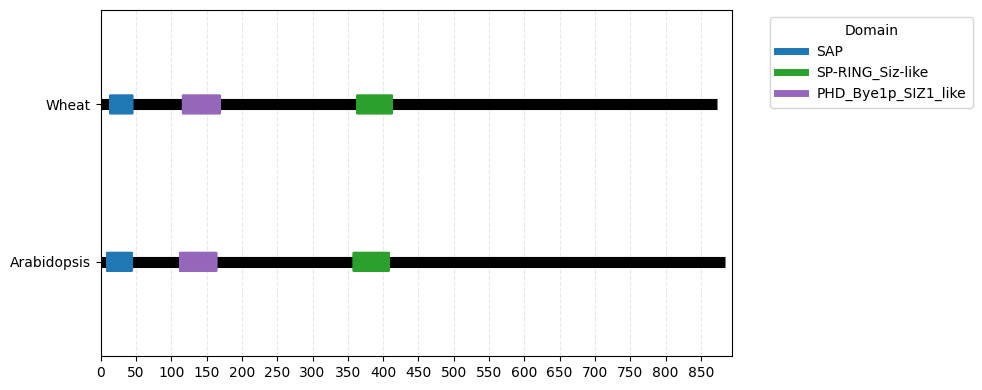

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle
import numpy as np
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 4))

regions = ['SAP','SP-RING_Siz-like', 'PHD_Bye1p_SIZ1_like']
colors = plt.cm.tab20(np.linspace(0, 1, 6))
domain_colors = {region: color for region, color in zip(regions, colors)}

arab_length = len(arab_protein_record.seq)
wheat_length = len(wheat_protein_record.seq)

max_length = max(arab_length, wheat_length)
ax.set_xlim(0, max_length+10)
ax.set_ylim(0.35, 0.9)

ticks = np.arange(0, max_length + 1, 50)
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

# Arabidopsis
arab_length = len(arab_protein_record.seq)
ax.hlines(y=0.5, xmin=0, xmax=arab_length, color='black', lw=8)

for domain in arab_domains:
    start = domain['start'] - 1
    end = domain['end'] - 1
    ax.add_patch(FancyBboxPatch(
        (start, 0.485),
        end - start,
        0.03,
        boxstyle='round,pad=0,rounding_size=0.03',
        edgecolor=domain_colors[domain['name']],
        facecolor=domain_colors[domain['name']],
        alpha=1,
        zorder=3
    ))

# Wheat 
wheat_length = len(wheat_protein_record.seq)
ax.hlines(y=0.75, xmin=0, xmax=wheat_length, color='black', lw=8)

for domain in wheat_domains:
    start = domain['start'] - 1
    end = domain['end'] - 1
    ax.add_patch(FancyBboxPatch(
        (start, 0.735),
        end - start,
        0.03,
        boxstyle='round,pad=0,rounding_size=0.03',
        edgecolor=domain_colors[domain['name']],
        facecolor=domain_colors[domain['name']],
        alpha=1,
        zorder=3
    ))

proxies = [
    Line2D([0], [0], color=color, lw=5, label=region)
    for region, color in domain_colors.items()
]

ax.legend(
    proxies,
    regions,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    title='Domain',
    borderpad=0.5,
    borderaxespad=0.5
)

ax.set_yticks([0.5, 0.75])
ax.set_yticklabels(['Arabidopsis', 'Wheat'])
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()

new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
# plt.savefig("domain_architecture.svg")



# Align conserved domains

In [13]:
def get_domain_sequence(protein_seq, domain):
    return protein_seq[domain["start"]:domain["end"]]

arab_domains_seq = {d["name"]: get_domain_sequence(arab_protein_record.seq, d) 
                   for d in arab_domains}
wheat_domains_seq = {d["name"]: get_domain_sequence(wheat_protein_record.seq, d) 
                    for d in wheat_domains}

In [ ]:
from Bio.Align import AlignInfo, MultipleSeqAlignment
from Bio import pairwise2
from Bio.Align.Applications import MafftCommandline

domains = ["SAP", "SP-RING_Siz-like", "PHD_Bye1p_SIZ1_like"]
for domain in domains:
    sap_arab = arab_domains_seq[domain]
    sap_wheat = wheat_domains_seq[domain]

    alignments = pairwise2.align.globalms(sap_wheat, sap_arab, 2, -1, -.5, -.1)
    print(f'Domain: {domain}')
    print(pairwise2.format_alignment(*alignments[0]))

Domain: SAP
---FRIKELKDI-LH-QLGLP-KQGKKQD-LI-DRV-LA-LL
   ||||||||  |  ||||  ||||||  |  ||  |  ||
LSYFRIKELKD-VL-TQLGL-SKQGKKQ-EL-VDR-IL-TLL
  Score=42.3

Domain: SP-RING_Siz-like
NLRCPN-SGSRM-KT-AGRFK-PCI-HMGCFDLDT-FVELNQRSRKWQCPICLKNY
|||||  ||||  |  ||||  ||  ||||||||  ||||||||||||||||||||
NLRCP-MSGSR-IK-VAGRF-LPC-VHMGCFDLD-VFVELNQRSRKWQCPICLKNY
  Score=82

Domain: PHD_Bye1p_SIZ1_like
RCI-CD--SKLLN--DN-MIQCEDD-RCHVWQHMS--CV-LVPDKPTEGV--G-PEVP-PH--FYCEL-C
||  |   |  |   |  ||||| | |||||||    || | ||||      | |  | |   ||||  |
RC-VC-GNS--L-ETD-SMIQCE-DPRCHVWQH--VGCVIL-PDKP----MDGNP--PLP-ESFYCE-IC
  Score=56.9



# Find domains for all proteins

In [14]:
from Bio.Align import AlignInfo, MultipleSeqAlignment
from Bio import pairwise2
from Bio.Blast.Applications import NcbiblastpCommandline
import tempfile
from Bio.Blast import NCBIXML

def run_blast(query_seq, subject_seq):
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as query_file, \
         tempfile.NamedTemporaryFile(mode='w', delete=False) as subject_file:
        query_file.write(f">query\n{query_seq}")
        subject_file.write(f">subject\n{subject_seq}")
        query_file.flush()
        subject_file.flush()
        
        blast_output = tempfile.NamedTemporaryFile(mode='w', delete=False)
        blastp_cline = NcbiblastpCommandline(query=query_file.name, subject=subject_file.name, outfmt=5, out=blast_output.name)
        stdout, stderr = blastp_cline()

        # Parse the XML output
        with open(blast_output.name) as result_handle:
            blast_record = NCBIXML.read(result_handle)
            
        # Get the top hit sequence
        top_hit_seq = None
        if blast_record.alignments:
            top_alignment = blast_record.alignments[0]
            if top_alignment.hsps:
                top_hsp = top_alignment.hsps[0]
                top_hit_seq = top_hsp.query

        # Clean up temporary files
        os.unlink(query_file.name)
        os.unlink(subject_file.name)
        os.unlink(blast_output.name)

        return top_hit_seq

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [15]:
domains = ["SAP", "SP-RING_Siz-like", "PHD_Bye1p_SIZ1_like"]
domain_top_values = {"SAP": 70, "SP-RING_Siz-like": 100, "PHD_Bye1p_SIZ1_like": 104}
ortho = "edited_Triticum_aestivum_TraesCS1A02G065700_orthologues.fa"
protein_dict = {record.id: record.seq for record in SeqIO.parse(ortho, "fasta")}

In [65]:
domain_results = {}

for domain in domains:
    for id,seq in protein_dict.items():
        sap_arab = arab_domains_seq[domain]
        blast_output = run_blast(seq, sap_arab)
        if blast_output is None:
            print(f'No hit for {domain}-{id}')
            if id not in domain_results:
                domain_results[id] = {}
            domain_results[id][domain] = 0
            continue

        alignments = pairwise2.align.globalms(blast_output, sap_arab, 2, -1, -.5, -.1)
        score = alignments[0].score
        normalised_score = score/domain_top_values[domain]
        
        if id not in domain_results:
            domain_results[id] = {}
        
        domain_results[id][domain] = normalised_score
        
        # print(f'Domain: {domain}-{id}')
        # print(f'Score: {score}')
        # print(f'Normalised score: {score/domain_top_values[domain]}')
        # print(pairwise2.format_alignment(*alignments[0]))


No hit for SAP-Sspon.07G0014490-1A-mRNA-1
No hit for SAP-Sspon.07G0026940-1B-mRNA-1:cds
No hit for SAP-Sspon.07G0014450-4D-mRNA-1:cds
No hit for SAP-OIT36160
No hit for SAP-OIT20895
No hit for PHD_Bye1p_SIZ1_like-YOR156C


In [380]:
import csv
with open("domain_results.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "SAP", "SP-RING_Siz-like", "PHD_Bye1p_SIZ1_like"])
    for id, scores in domain_results.items():
        writer.writerow([id, scores["SAP"], scores["SP-RING_Siz-like"], scores["PHD_Bye1p_SIZ1_like"]])

# BLAST to get pct similarity of whole protein seq

In [16]:
total_score_arab = 1768
total_score_wheat = 1746

pct_similarity_dict = {}

for id,seq in protein_dict.items():
    if id not in pct_similarity_dict:
        pct_similarity_dict[id] = {}
    
    arab_blast_output = run_blast(seq, str(arab_protein_record.seq))
    arab_alignments = pairwise2.align.globalms(arab_blast_output, str(arab_protein_record.seq), 2, -1, -.5, -.1)
    arab_score = arab_alignments[0].score
    pct_similarity_dict[id]["arab"] = arab_score/total_score_arab
    
    wheat_blast_output = run_blast(seq, str(wheat_protein_record.seq))
    wheat_alignments = pairwise2.align.globalms(wheat_blast_output, str(wheat_protein_record.seq), 2, -1, -.5, -.1)
    wheat_score = wheat_alignments[0].score
    pct_similarity_dict[id]["wheat"] = wheat_score/total_score_wheat
    
# print(f'TaSIZ1 score: {score/total_score_wheat}')
# print(f'AtSIZ1 score: {score/total_score_arab}')

In [391]:
with open("pct_similarity_results.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "Arabidopsis", "Wheat"])
    for id, scores in pct_similarity_dict.items():
        writer.writerow([id, scores["arab"], scores["wheat"]])

In [85]:
import csv

checked = set(pct_similarity_dict.keys())

id_to_name = {}
with open("just-tree-names.csv", "r") as f2:
    reader2 = csv.reader(f2)
    for row in reader2:
        id_to_name[row[0]] = row[1]

with open("EDIT-THIS-FOR-HEATMAP-ON-TREE.csv", "r") as f, open("EDITED-FOR-HEATMAP-ON-TREE-ALLREGIONS.csv", "w") as fout:
    reader = csv.reader(f)
    writer = csv.writer(fout)
    writer.writerow(["ID", "Species", "Arabidopsis", "Wheat", "SAP", "SP-RING_Siz-like", "PHD_Bye1p_SIZ1_like", "length"])
    for line in reader:
        try:
            new_line = line[0][::-1].split('_', 1)[1][::-1]
        except:
            continue
        if new_line.endswith("_cds"):
            new_line = new_line.replace("_cds", ":cds")
        if new_line in pct_similarity_dict:
            if line[0] in id_to_name:
                line.append(id_to_name[line[0]])
            line.append(pct_similarity_dict[new_line]["arab"])
            line.append(pct_similarity_dict[new_line]["wheat"])
            line.append(domain_results[new_line]["SAP"])
            line.append(domain_results[new_line]["SP-RING_Siz-like"])
            line.append(domain_results[new_line]["PHD_Bye1p_SIZ1_like"])
            line.append(len(protein_dict[new_line]))
            checked.remove(new_line)
        else:
            continue
        writer.writerow(line)
        
# print(f'missing: {checked}')

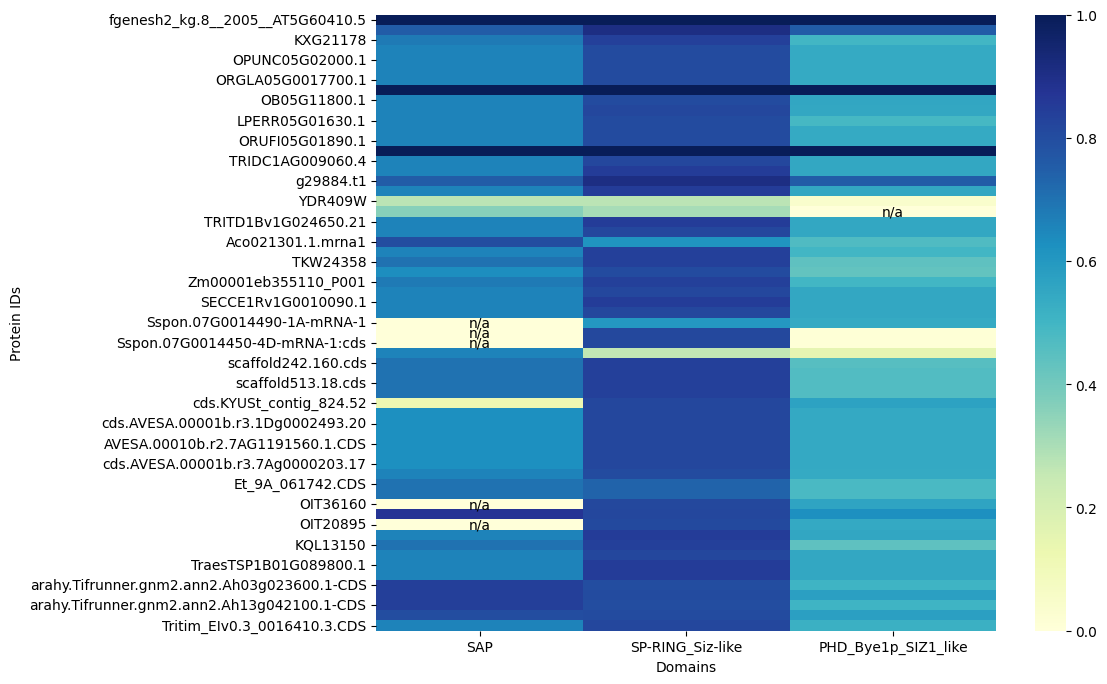

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# df = pd.DataFrame(domain_results).T

# mask = df == 0

# plt.figure(figsize=(10, 8))
# ax = sns.heatmap(df, annot=False, cmap="YlGnBu", cbar=True)

# for i in range(df.shape[0]):
#     for j in range(df.shape[1]):
#         if mask.iloc[i, j]:
#             ax.text(j + 0.5, i + 0.5, 'n/a', color='black', ha='center', va='center')

# plt.xlabel('Domains')
# plt.ylabel('Protein IDs')
# new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}
# mpl.rcParams.update(new_rc_params)
# plt.savefig("domain_heatmap.svg")